## Time-series based analysis of Earthquake Risk Factors

### Part 4: Performing linear regression

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score




import pickle

### Part 2.1: Prepping Loma Prieta EQ's:

In [2]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_lp_eq = pd.read_csv(file_path)
df_lp_eq.drop(columns = "Unnamed: 0", inplace = True)

df_lp_eq["time"] = pd.to_datetime(df_lp_eq["time"])

df_lp_eq.sort_values(by = "time", inplace=True)


df_lp_eq.reset_index(drop = True, inplace=True)
df_lp_eq.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_lp_eq.head()

,time,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth
0,1989-10-09 01:38:42.380,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805
1,1989-10-09 02:07:50.370,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137
2,1989-10-09 02:15:01.850,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826
3,1989-10-09 03:54:18.030,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985
4,1989-10-09 04:18:04.350,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540


In [3]:
df_lp_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1271 non-null   datetime64[ns]
 1   mag        1271 non-null   float64       
 2   sig        1271 non-null   int64         
 3   dmin       1153 non-null   float64       
 4   rms        1270 non-null   float64       
 5   gap        1270 non-null   float64       
 6   magType    1271 non-null   object        
 7   longitude  1271 non-null   float64       
 8   latitude   1271 non-null   float64       
 9   depth      1271 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 99.4+ KB


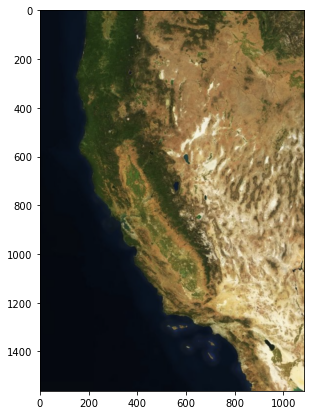

In [4]:
plt.figure(figsize = (10,7))
im = plt.imread("../assets/Satellite_map_region.png")
implot = plt.imshow(im)



plt.savefig("../plots/Area_map.png")



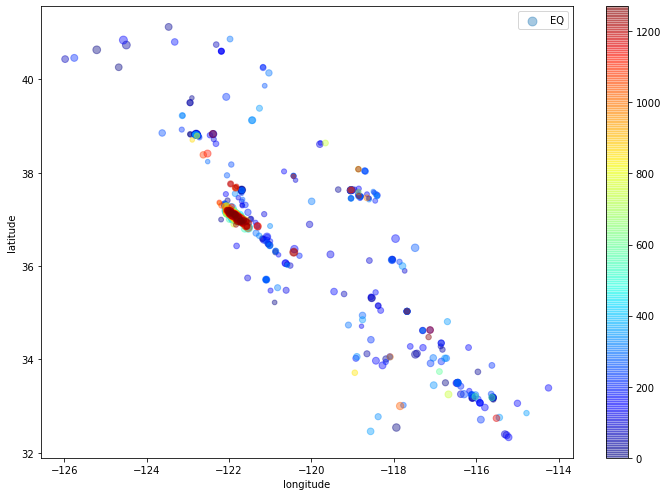

In [5]:
ax = plt.gca()


df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

## Finding the main failure time:

In [6]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float
import datetime as dt

epoch = dt.datetime(1970, 1, 1)

time = []
for t in [(d - epoch).total_seconds() for d in df_lp_eq["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_lp_eq["time_seconds"] = time

failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

df_lp_eq["time_to_failure_sec"] = np.array(df_lp_eq["time_seconds"]) - np.array(failure_event["time_seconds"])


In [7]:
df_lp_eq.drop(columns=["time", "time_seconds"], inplace=True)


df_lp_eq.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805,-771932.81
1,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137,-770184.82
2,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826,-769753.34
3,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985,-763797.16
4,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540,-762370.84


Checking if failure is correctly zero:

In [8]:
failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

failure_event

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
356,6.9,1602,0.008108,0.08,89.0,mh,-121.879833,37.036167,17.214,0.0


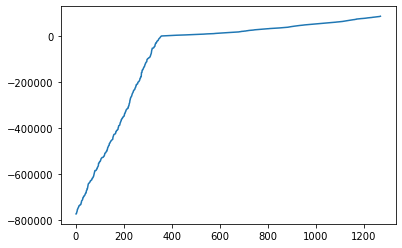

In [9]:
plt.plot(df_lp_eq["time_to_failure_sec"])

# 3D clustering with long-lat-depth

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Standardizing the data:

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


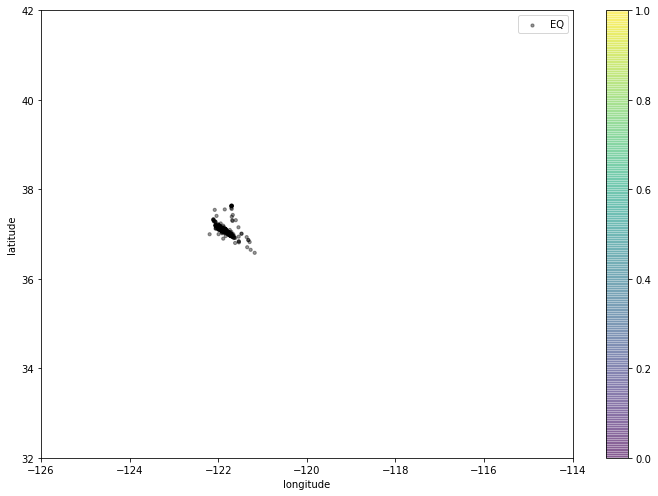

In [11]:
#Creating the df for creating the clusters

df_lp_eq_cut = df_lp_eq

df_lp_eq_cut_cut = df_lp_eq_cut.iloc[0:800,:]

df = df_lp_eq_cut_cut[["longitude", "latitude", "depth"]]

ss = StandardScaler()

X_scaled = ss.fit_transform(df)

dbscan = DBSCAN(eps = 0.2, min_samples=5)

dbscan.fit(X_scaled);

df['cluster'] = dbscan.labels_


df_2 = df_lp_eq.copy()

df_2["cluster"] = df["cluster"]


# Getting the top cluster
Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


# Plotting the top cluster
if (Top_clusters[0] < 0):
    cluster_mask = Top_clusters[1]
else:
    cluster_mask = Top_clusters[0]
    

ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="latitude",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
    ylim=(32, 42)
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example.png")


In [12]:
df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)

cluster
 1.0     470
-1.0     159
 5.0      57
 2.0      53
 7.0       8
 3.0       8
 0.0       8
 6.0       7
 4.0       7
 11.0      6
 10.0      6
 8.0       6
 9.0       5
Name: cluster, dtype: int64

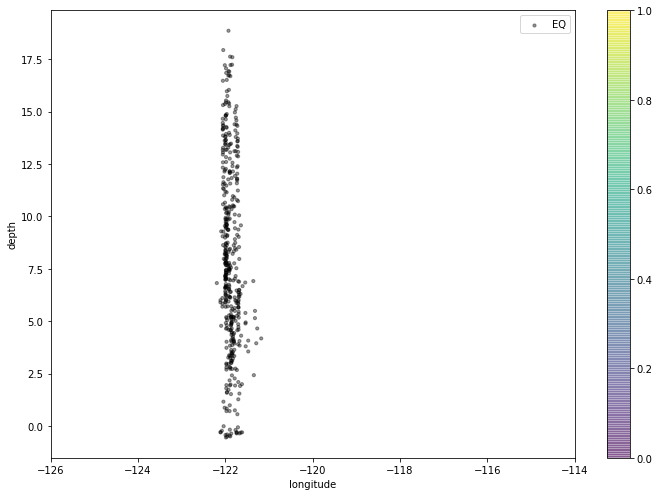

In [13]:
ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="depth",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example_depth.png")



# Moving clusters design

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

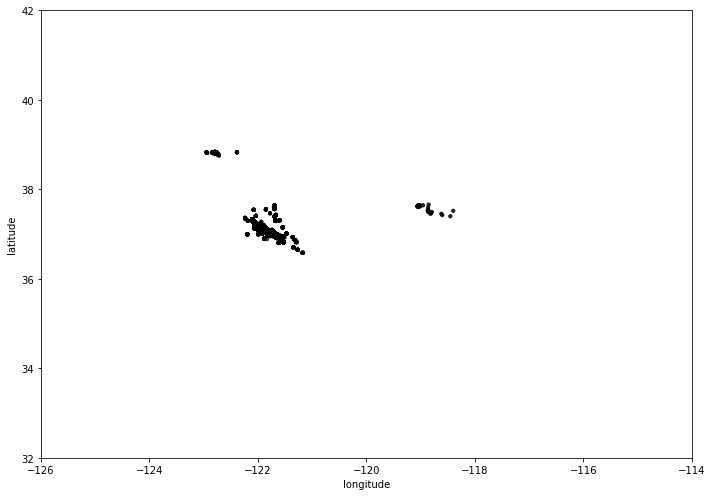

In [14]:
data = {"mag_mean": 0, "density": 0, "long_cent": 0, "long_std": 0,
                  "lat_cent": 0, "lat_std": 0, "dept_cent": 0, "dept_std": 0, "time_to_failure": 0}

cluster_df = pd.DataFrame(data, index=[0])



df_lp_eq_cut = df_lp_eq
cnt = 0
ax = plt.gca()
for i in range(40, len(df_lp_eq_cut), 20):

    df_lp_eq_cut_cut = df_lp_eq_cut.iloc[:i,:]

    df = df_lp_eq_cut_cut[["longitude", "latitude", "depth", "mag", "time_to_failure_sec"]]

    ss = StandardScaler()

    X_scaled = ss.fit_transform(df[["longitude", "latitude", "depth"]])

    dbscan = DBSCAN(eps = 0.2, min_samples=5)

    dbscan.fit(X_scaled);

    df['cluster'] = dbscan.labels_


    df_2 = df_lp_eq.copy()

    df_2["cluster"] = df["cluster"]


    # Getting the top cluster
    Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


    # Plotting the top cluster
    if (Top_clusters[0] < 0):
        cluster_mask = Top_clusters[1]
    else:
        cluster_mask = Top_clusters[0]

    df_selected = df[df["cluster"] == cluster_mask]   

    
    
    
    df_selected.plot(kind="scatter", x="longitude", y="latitude",
        s=[10] * len(df_selected),
        c="black",
        cmap=plt.get_cmap("jet"),
        alpha=0.4, 
        figsize=(10,7), ax = ax,
        xlim=(-126, -114),
        ylim=(32, 42)
    )

    plt.tight_layout()
    
    plt.savefig(f"../plots/cluster_example{cnt}.png")
    cnt+=1
    


    max_lat = df_selected["latitude"].max()
    min_lat = df_selected["latitude"].min()
    max_long = df_selected["longitude"].max()
    min_long = df_selected["longitude"].min()

    area = (max_lat - min_lat)*(max_long - min_long)
    cluster_density = area / len(df_selected)

    cluster_mag_mean = df_selected["mag"].mean()

    cluster_long_cent = df_selected["longitude"].mean()

    cluster_long_std = df_selected["longitude"].std()

    cluster_lat_cent = df_selected["latitude"].mean()

    cluster_lat_std = df_selected["latitude"].std()

    cluster_dept_cent = df_selected["depth"].mean()

    cluster_dept_std = df_selected["depth"].std()


    cluster_time_to_failure = df_selected["time_to_failure_sec"].iloc[-1]

    rows = [cluster_mag_mean, cluster_density, cluster_long_cent, cluster_long_std,
                      cluster_lat_cent, cluster_lat_std, cluster_dept_cent, cluster_dept_std, cluster_time_to_failure
                      ]


    cluster_df.loc[len(cluster_df)] = rows

cluster_df.drop(cluster_df.index[0], inplace=True)



cluster_df["long_mov"] = cluster_df["long_cent"].diff()
cluster_df["lat_mov"] = cluster_df["long_cent"].diff()

cluster_df.dropna(inplace = True)


cluster_df.reset_index(inplace=True)

cluster_df.drop(columns = "index", inplace=True)





In [15]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mag_mean         61 non-null     float64
 1   density          61 non-null     float64
 2   long_cent        61 non-null     float64
 3   long_std         61 non-null     float64
 4   lat_cent         61 non-null     float64
 5   lat_std          61 non-null     float64
 6   dept_cent        61 non-null     float64
 7   dept_std         61 non-null     float64
 8   time_to_failure  61 non-null     float64
 9   long_mov         61 non-null     float64
 10  lat_mov          61 non-null     float64
dtypes: float64(11)
memory usage: 5.4 KB


In [16]:
cluster_df.head(20)

,mag_mean,density,long_cent,long_std,lat_cent,lat_std,dept_cent,dept_std,time_to_failure,long_mov,lat_mov
0,1.817143,0.000069,-121.698857,0.003696,37.625262,0.018153,5.701857,0.503937,-695607.07,0.049372,0.049372
1,1.446364,0.001264,-122.825621,0.067591,38.819561,0.019928,0.685455,0.903567,-583846.46,-1.126764,-1.126764
2,1.613158,0.000732,-122.812868,0.055074,38.820833,0.016129,0.569474,0.924783,-569810.40,0.012753,0.012753
3,1.638636,0.001617,-122.789091,0.104575,38.820788,0.016273,0.543227,0.886028,-515656.25,0.023778,0.023778
4,1.615652,0.001547,-122.789210,0.102173,38.820659,0.015911,0.530739,0.867726,-484348.49,-0.000119,-0.000119
5,1.615652,0.001547,-122.789210,0.102173,38.820659,0.015911,0.530739,0.867726,-484348.49,0.000000,0.000000
6,1.599200,0.001423,-122.787953,0.098092,38.819960,0.017019,0.644040,0.933101,-396304.77,0.001257,0.001257
7,1.624286,0.001272,-122.773512,0.119683,38.820101,0.016198,0.587750,0.939037,-349998.99,0.014441,0.014441
8,1.586765,0.001047,-122.777892,0.109289,38.819799,0.015512,0.615441,0.890831,-313855.76,-0.004380,-0.004380
9,1.550263,0.001181,-122.779671,0.104506,38.817500,0.018204,0.539395,0.934920,-239262.22,-0.001779,-0.001779


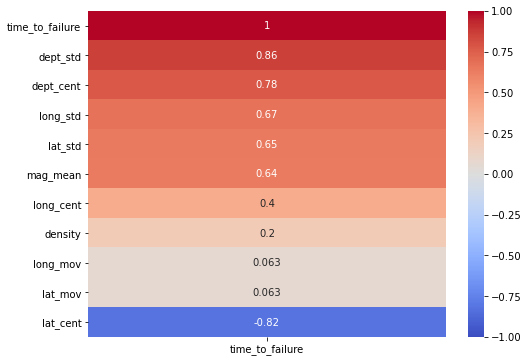

In [17]:
import seaborn as sns


df_corr = cluster_df.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr[['time_to_failure']].sort_values(by=['time_to_failure'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.savefig("../plots/EDA_corr_plots.png")

In [18]:
# Step 3: Instantiate the model
lr = LinearRegression()
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = cluster_df.drop(columns=["time_to_failure", "long_cent", "lat_cent"])

ss = StandardScaler()

X_scaled = ss.fit_transform(X)

pickle.dump(ss, open('../datasets/ss.pkl', 'wb'))

# We need a y vector that is length n
y = cluster_df["time_to_failure"]

lr.fit(X_scaled, y)

y_pred = lr.predict(X_scaled)


lr.score(X_scaled, y)

0.8845382808079404

In [19]:
X.head()

,mag_mean,density,long_std,lat_std,dept_cent,dept_std,long_mov,lat_mov
0,1.817143,0.000069,0.003696,0.018153,5.701857,0.503937,0.049372,0.049372
1,1.446364,0.001264,0.067591,0.019928,0.685455,0.903567,-1.126764,-1.126764
2,1.613158,0.000732,0.055074,0.016129,0.569474,0.924783,0.012753,0.012753
3,1.638636,0.001617,0.104575,0.016273,0.543227,0.886028,0.023778,0.023778
4,1.615652,0.001547,0.102173,0.015911,0.530739,0.867726,-0.000119,-0.000119


In [20]:
coef_df = pd.DataFrame({'features': list(X.columns), 
              'coef' : list(lr.coef_)})

coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('coef', ascending = False)
coef_df.head(10)

,coef
features,
dept_std,138043.374255
long_std,121599.201864
lat_std,52312.224464
dept_cent,26483.639092
lat_mov,-2142.378806
long_mov,-2142.378806
density,-60513.901614
mag_mean,-112896.713635


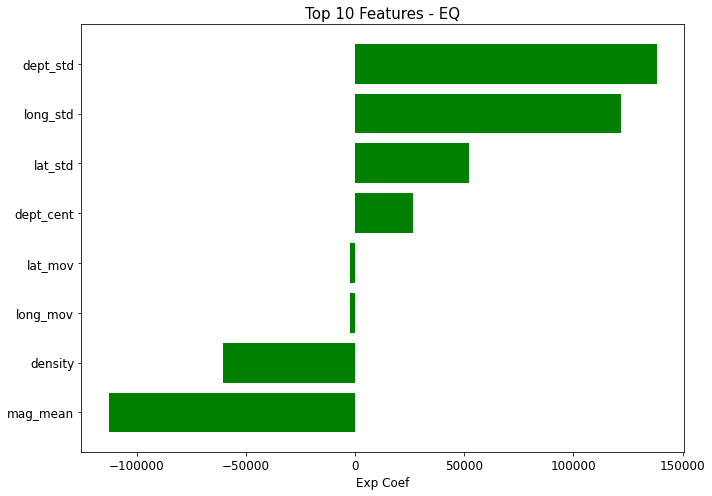

In [21]:
weights = coef_df['coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,7))
plt.barh(labels, weights, color = 'green')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Exp Coef', fontsize=12)
plt.title(f'Top 10 Features - EQ', fontsize=15)
plt.tight_layout()

plt.savefig("../plots/features.png")

In [22]:
cluster_df.head(1)

,mag_mean,density,long_cent,long_std,lat_cent,lat_std,dept_cent,dept_std,time_to_failure,long_mov,lat_mov
0,1.817143,0.000069,-121.698857,0.003696,37.625262,0.018153,5.701857,0.503937,-695607.07,0.049372,0.049372


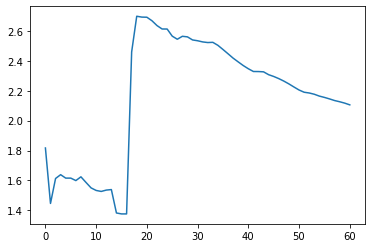

In [23]:
plt.plot(cluster_df["mag_mean"])

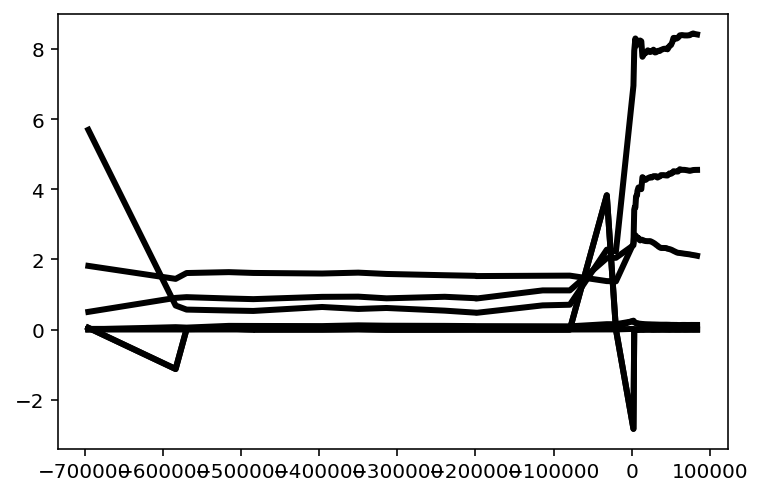

In [24]:
%config InlineBackend.figure_format = 'retina'

columns = list(cluster_df.columns)

columns.remove('time_to_failure')
columns.remove('long_cent')
columns.remove('lat_cent')


color = ["black", "red", "blue", "green", "purple"]


for i, label in enumerate(columns):
    
    plt.plot(cluster_df['time_to_failure'], cluster_df[label], color = "black", linewidth = 3)



In [25]:
print("Hello World!")

Hello World!
